In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import pandas as pd
import json
import fitsio
import time
import pickle
import re

%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.coreRL.offline_dataset import OfflineDELVEDataset
from survey_ops.coreRL.agents import Agent
from survey_ops.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.sys_utils import seed_everything
from survey_ops.coreRL.data_processing import load_raw_data_to_dataframe


In [3]:
from survey_ops.utils import ephemerides
from tqdm import tqdm
from pathlib import Path

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import entropy

In [5]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load config and lookup files

In [6]:
results_outdir = '../experiment_results/nside16/bc-azel-4years/'

In [7]:
with open('../configs/global_config.json', 'r') as f:
    gcfg = json.load(f)

In [8]:
with open(results_outdir + 'config.json', 'r') as f:
    cfg = json.load(f)

In [9]:
nside = cfg['data']['nside']

In [10]:
with open(gcfg['paths']['LOOKUP_DIR'] + '/' + gcfg['files']['FIELD2NVISITS'], 'r') as f:
    field2nvisits = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NAME'], 'r') as f:
#     field2name = json.load(f)
with open(gcfg['paths']['LOOKUP_DIR'] + '/' + gcfg['files']['FIELD2RADEC'], 'r') as f:
    field2radec = json.load(f)
with open(f'../data/lookups/nside{nside}_bin2azel.json', 'r') as f:
    bin2azel = json.load(f)
with open(f'../data/lookups/nside{nside}_bin2radec.json', 'r') as f:
    bin2radec = json.load(f)

In [11]:
with open('../experiment_results/nside16/bc-azel-4years/evaluation_1/eval_metrics.pkl', 'rb') as f:
    eval_metrics = pickle.load(f)

In [12]:
eval_metrics

{'ep-0': {'glob_observations': {'night-0': array([[ 0.3767364 ,  0.9263205 , -0.335614  , ..., -0.13070813,
            0.        ,  0.1729779 ],
          [ 0.7528875 ,  0.65814924, -0.7386258 , ..., -0.13475417,
            0.38      ,  0.17697448],
          [ 0.8294624 ,  0.5585625 , -0.7339297 , ..., -0.13878854,
            0.78      ,  0.18097009],
          ...,
          [ 0.20050327,  0.97969306, -0.38562575, ..., -0.3870527 ,
            0.78      ,  0.4726502 ],
          [ 0.16822705,  0.9857483 , -0.37435648, ..., -0.38955855,
            0.92      ,  0.4766458 ],
          [ 0.09734084,  0.9952511 , -0.38223448, ..., -0.3920315 ,
            0.64      ,  0.48064142]], shape=(78, 23), dtype=float32),
   'night-1': array([[ 0.01111803,  0.9999382 , -0.335199  ,  1.        ,  0.        ,
            1.        ,  1.        ,  1.        ,  0.        ,  0.3436627 ,
           -0.9390932 , -0.24608749, -0.9176502 , -0.39738902, -0.3779832 ,
            0.8139159 , -0.58098274, 

In [15]:
eval_metrics['ep-0']['field_id']['night-0']

array([   -1, 16162, 16151, 16161, 16129, 16151, 16129, 16159, 16125,
       16159, 16164, 16159, 16151, 16147, 16147, 16135, 16157, 16157,
       16162, 16162, 16157, 16134, 16134, 16162, 16163, 16135, 16138,
       16137, 16133, 16138, 16133, 16137, 16136, 16160, 16136, 16160,
       16160, 16158, 16139, 16139, 16166, 15577, 14370,  3750, 13643,
       13592,  9691, 10793,  3388, 15683,  9634,  8020,  9640,  5596,
        5820,  8099,  6183,  6249,  5790, 15962,  5784, 13798,  6165,
       15945, 11152, 11157, 11208,  8329, 15972, 10672, 15973,  5823,
        5904,  3379, 15952,  4093,  3289, 10524])

In [ ]:
eval_zenith_mask = eval_metrics['ep-0']['field_id'] != -1

In [13]:
# fits_path = Path(cfg.get('paths.DFITS')).resolve().parents[1] / 'data' / cfg.get('paths.DFITS')
# json_path = Path(cfg.get('paths.DJSON')).resolve().parents[1] / 'data' / cfg.get('paths.DJSON')

df = load_raw_data_to_dataframe(fits_path=None, json_path='../data/fits/decam-exposures-20251211.json')

d = OfflineDELVEDataset(
    df=df,
    cfg=cfg,
    gcfg=gcfg,
)

Calculating sun and moon ra/dec and az/el:  42%|███████████████████████████████████████████████████████████████▎                                                                                      | 22792/54031 [00:18<00:25, 1208.34it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x79e21b587710>>
Traceback (most recent call last):
  File "/home/hurra/.conda/envs/cosmoML/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [47]:
with open(results_outdir + 'evaluation_1/eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)['ep-0']

In [48]:
from survey_ops.coreRL.data_processing import expand_feature_names_for_cyclic_norm

In [49]:
feature_names = expand_feature_names_for_cyclic_norm(cfg['data']['additional_bin_features'], gcfg['features']['CYCLICAL_FEATURE_NAMES'])

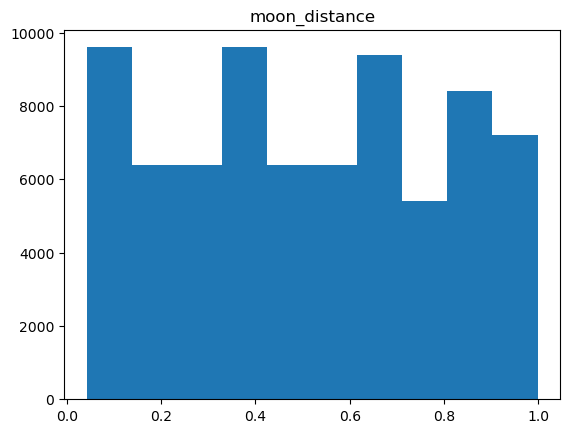

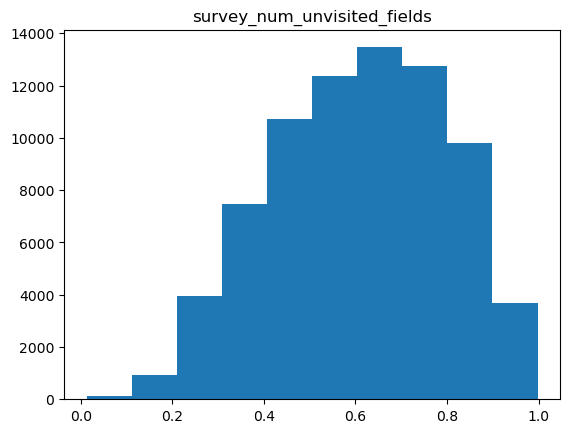

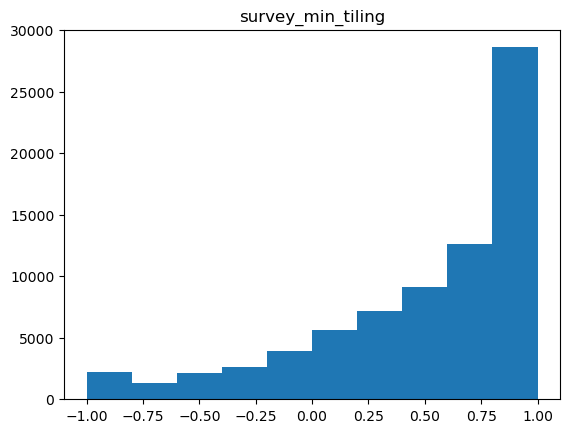

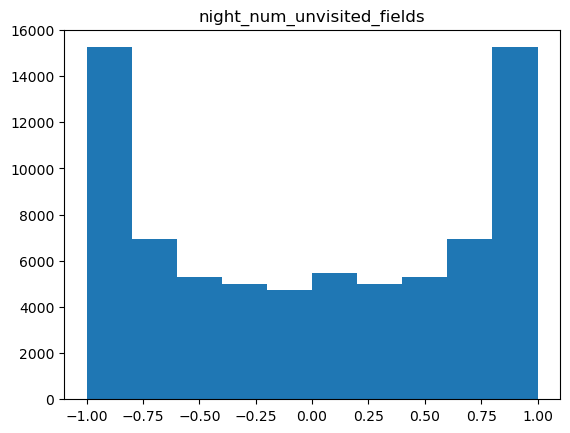

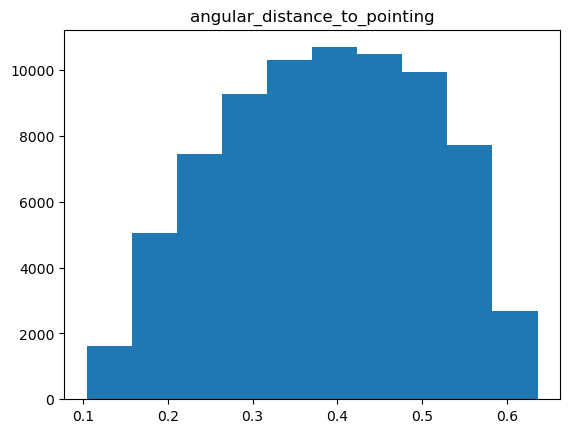

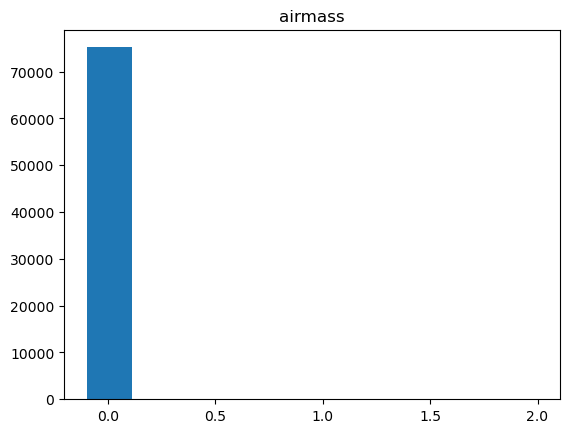

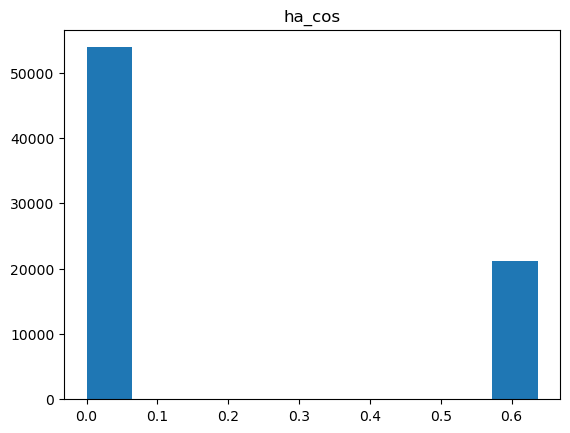

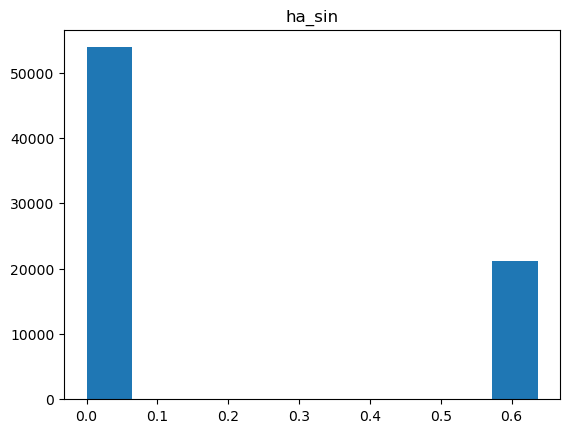

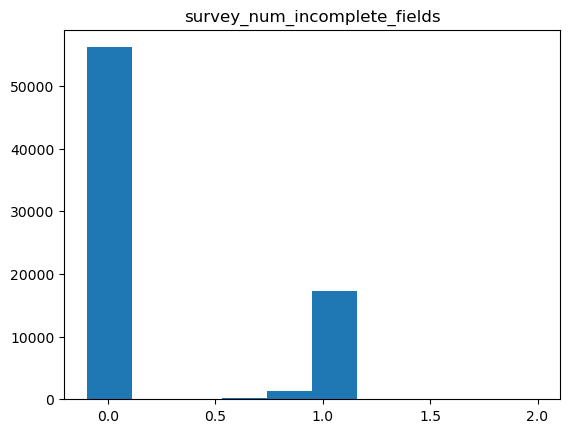

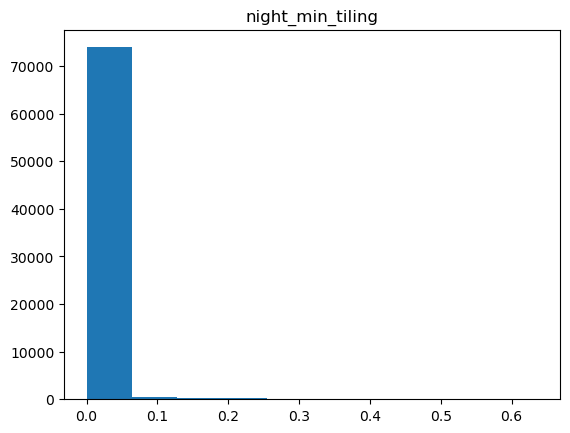

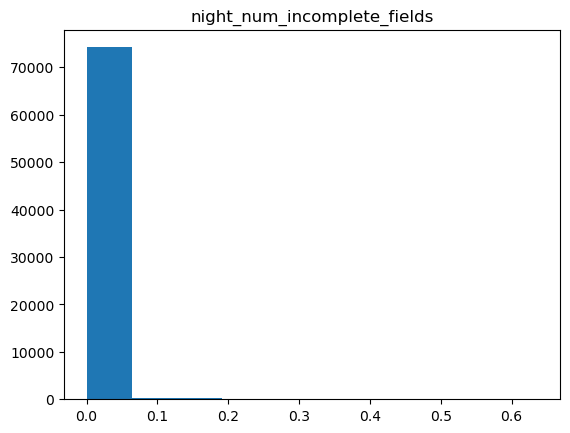

In [50]:
for i, feat_row in enumerate(eval_metrics['bin_observations']['night-0'].T):
    plt.hist(feat_row.flatten())
    plt.title(feature_names[i])
    plt.show()

In [15]:
eval_metrics.keys()

dict_keys(['glob_observations', 'bin_observations', 'rewards', 'timestamp', 'field_id', 'bin'])